# PyTorch Workflow

Vamos explorar um workflow de uso do PyTorch do início ao fim

Recurso
1. Versão em e-book: https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
import torch
from torch import nn ## nn contém tudo sobre redes neurais
import matplotlib.pyplot as plt

torch.__version__

'1.13.0+cu116'

## 1. Dados (preparando e carregando)

Dados podem ser qualquer coisa em ML

* Planilha Excel
* Imagens
* Videos
* Audio
* DNA
* Texto

ML é um jogo de duas partes:
1. Conseguir uma representação numérica dos dados
2. Construir um modelo para aprender os padrões dessa representação numérica

Vamos criar um conjunto de dados de acordo com a fórmula de regressão linear e **parâmetros** conhecidos.

In [2]:
# Criando parâmetros
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Dividindo os dados em treino e teste

Precisamos de dados para
1. Treinamento (60-80%)
2. Validação  (10-20%)
3. Teste  (10-20%)

O objetivo é atingir generalização, ou seja, conseguir performar bem em novos dados nunca vistos no treino.

Aqui não temos a ajuda do sklearn.

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plota os dados de treino e de teste e compara as predições
  """

  plt.figure(figsize=(10, 7))
  size = 20
  plt.scatter(train_data, train_labels, c="b", s=size, label="Treino")

  plt.scatter(test_data, test_labels, c="g", s=size, label="Teste")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=size, label="Predições")
  
  plt.legend(prop={"size": 14})

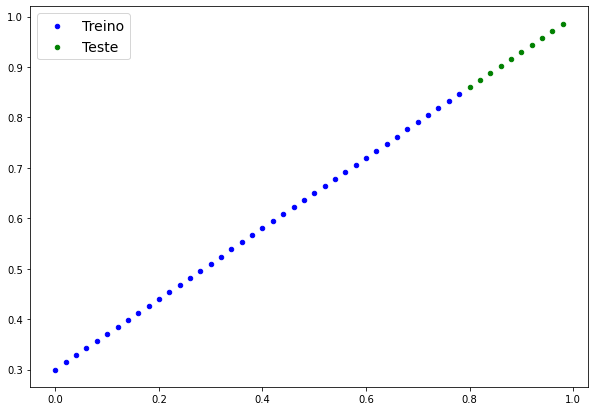

In [6]:
plot_predictions()

## 2. Construindo um modelo

Nosso primeiro modelo PyTorch

O que o modelo faz:
* Começa com valores aleatórios (weight e bias)
* Olha para os dados de treino e ajusta os valores aleatórios para melhor representar os valores ideais

Como?

Por meio de dois algoritmos principais:
1. Gradient Descent
2. Backpropagation

In [7]:
# Criando uma classe para o modelo de regressão linear
import torch
from torch import nn

class LinearRegressionModel(nn.Module): # Quase tudo no PyTorch herda de nn.Module
  def __init__(self):
    super().__init__()

    #Aqui podem ser definidos quaisquer parâmetros aprendíveis 
    #Camadas, funções e, no caso, dois parâmetros simples
    self.weights = nn.Parameter(torch.randn(1,
                                              requires_grad = True, # pode ser att via gradient descent
                                              dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    # O módulo torch.autograd é o que realiza o gradient descent

  # Método forward para definir a computação no modelo
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias #Essa é a fórmula da regressão linear

### Essenciais para construção de modelos PyTorch

* torch.nn - Contém tudo relacionado para a construção de grafos computacionais (uma rede neural é um grafo computacional)
* torch.nn.Parameter - Quais parâmetros o modelo deve tentar aprender, geralmente, uma camada PyTorch vai defini-los para nós
* torch.nn.Module - A classe base para todos os modulos de rede neural. Deve ser sobrescrito ao herdar de Module
* torch.optim - Contém os otimizadores do PyTorch e ajudam no Gradient Descent

* def forward() - Todas as subclasses de nn.Module requerem que esse método seja sobrescrito. Ele define o que deve ser feito na forward pass

Recursos: https://pytorch.org/tutorials/beginner/ptcheat.html

### Checando o conteúdo do modelo

Podemos checar o que está dentro do modelo usando `.parameters()` ou `.state_dict()`

In [15]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Realizando predições usando `torch.inference_mode()`

Para testar o poder preditivo atual do modelo, vamos ver quão bem ele prediz `y_test` a partir de `X_test`.

Ao passar os dados pelo modelo, ele irá rodar pelo método `forward()`.

In [10]:
# Fazendo predições com o estado atual do modelo
with torch.inference_mode(): # O modo de inferência faz as predições serem mais rápidas
  y_preds = model_0(X_test)

# Também é possível usar o no_grad, mas o inference_mode é preferível
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

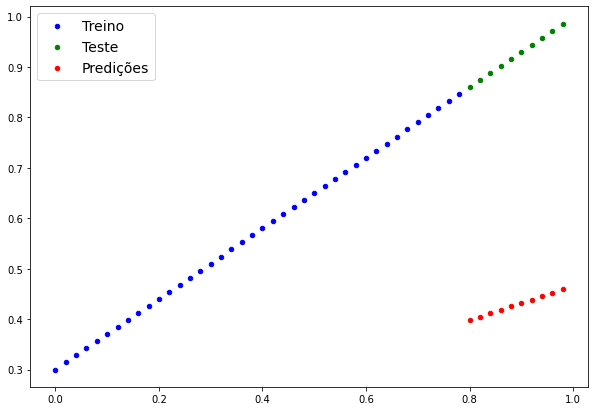

In [11]:
plot_predictions(predictions=y_preds)

## 3. Treinando o modelo

A ideia do treinamento é mover de parâmetros desconhecidos (aleatórios) para conhecidos.

Em outras palavras, partir de uma má representação para uma boa representação dos dados.

Uma forma de medir quão errado as predições do modelo estão, é usar uma função de perda (*loss function*).

* Nota: A função de perda também pode ser chamada de função de custo ou *criterion*.

Coisas que precisamos treinar:

* **Loss function:** Uma função para medir quão errado estão as predições do modelo com relação com as saídas ideais.

* **Otimizador**: Leva em consideração a perda do modelo e ajusta os parâmetros do modelo (weight e bias nesse caso) para melhorar a função de perda. - https://pytorch.org/docs/stable/optim.html

  * `params` - Os parâmetros do modelo que queremos otimizar
  * `lr` (learning rate) - É um hiperparâmetro que define quão grande/pequeno o otimizador muda os parâmetros a cada passo.

Especificamente para PyTorch:

* Um loop de treino
* Um loop de teste

In [16]:
# Definir uma loss func
loss_fn = nn.L1Loss()

# Definir um otimizador
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate

# O learning rate não precisa ser fixo:
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

### Construindo um loop de treinamento e de teste em PyTorch

Coisas que precisamos em um loop de treino:
0. Loop nos dados
1. Forward pass (propagation) para realizar predições nos dados
2. Calcular a perda (*loss*) ao comparar as predições com os valores almejados
3. Optimizer zero grad - Zera os gradientes para que eles não se acumulem
4. Loss backward (**backpropagation**) - Move do fim ao início da rede para calcular os gradientes de cada um dos parâmetros do modelo
5. Passo do otimizador - Usa do otimizador para ajustar os parÂmetros do modelo para melhorar a perda (**gradient descent**)

* Recurso: 
https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html


In [17]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
# Uma época é um loop pelos dados (ele é um hiperparâmetro)
epochs = 500

# Grava diferentes valores
epoch_count = []
loss_values = []
test_losses = []

# 0. Loop pelos dados
for epoch in range(epochs):
  # Define o modelo para o modo treino
  model_0.train() # Liga o rastreamento de gradientes

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the Loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Performa backpropagation
  # A forma como o otimizador funciona acumula ao longo do loop
  # Assim, devemos zerá-lo no passo 3
  loss.backward()

  # 5. Gradient Descent
  # Atualiza os valores dos parâmetros do modelo
  optimizer.step()

  ### Testando
  model_0.eval() # Desliga configurações não necessárias para teste

  with torch.inference_mode(): #Desliga rastreamento de gradientes e outras coisas
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calcular a loss
    test_loss = loss_fn(test_pred, y_test)

  # Printa o que está acontecendo
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    test_losses.append(test_loss.detach().numpy())
    loss_values.append(loss.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

Loss: 0.02479521557688713
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

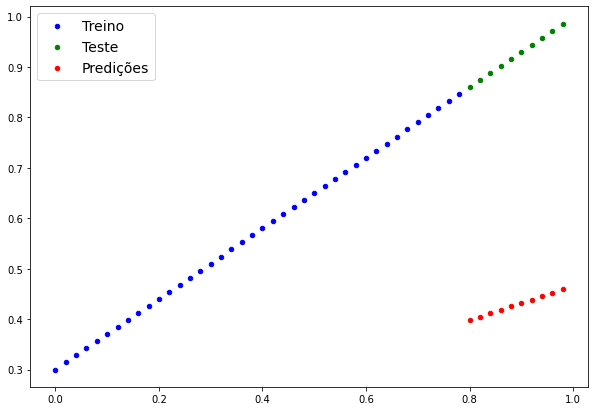

In [18]:
#Predições antigas com pesos aleatórios
plot_predictions(predictions=y_preds)

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

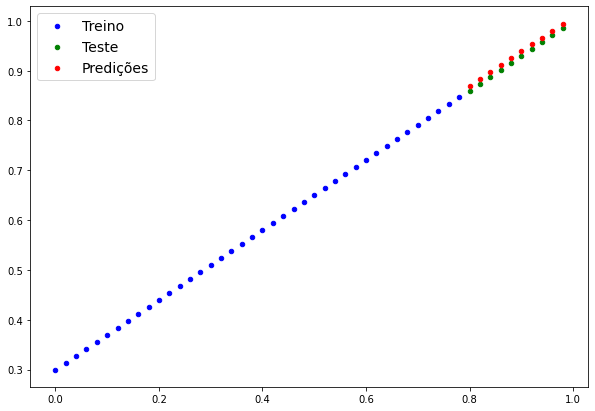

In [20]:
# Após treinamento
plot_predictions(predictions=y_preds_new)

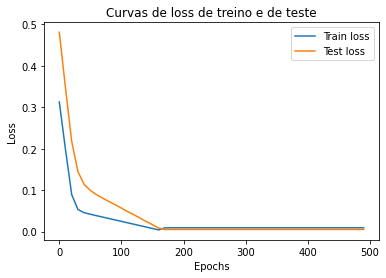

In [21]:
# Plota as curvas de loss
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_losses, label="Test loss")
plt.title("Curvas de loss de treino e de teste")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Salvando um modelo em PyTorch

Existem três formas principais para salvar e carregar modelos em PyTorch.

1. `torch.save()` - Permite salvar um objeto PyTorch em formato `pickle`.
2. `torch.load()` - Permite carregar um objeto PyTorch salvo
3. `torch.nn.Module.load_state_dict()` -  Permite carregar o dicionário de estados de um modelo

Recurso: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# Salvando o modelo PyTorch
from pathlib import Path

# 1. Cria pasta de modelos
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Cria o path do modelo
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Salvando o state_dict ( que é o recomendado )
print(f"Salvando modelo em: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Salvando modelo em: models/01_pytorch_workflow_model_0.pth


In [26]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Jan 13 20:08 01_pytorch_workflow_model_0.pth


## Carregando o modelo

Já que salvamos o `state_dict()` do modelo ao invés de ele todo, criaremos outra instância da classe do modelo e carregamos o `state_dict()` para esse novo.

In [28]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [32]:
# Fazendo predições para ter certeza
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

# Vendo se as predições batem
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Juntando tudo em um lugar

In [35]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.0+cu116'

Criando código agnóstico a *device*.

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando device: {device}") 

Usando device: cuda


# 6.1 Criando dados usando a fórmula de regressão linear y = weight * X + bias

In [38]:
real_weight = 0.7
real_bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # Sem o unsqueeze, erros aparecem
y = real_weight * X + real_bias

In [39]:
# Dividindo os dados
train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

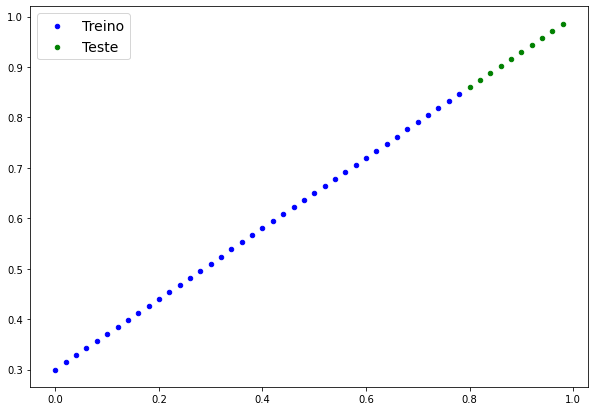

In [41]:
plot_predictions(X_train, y_train, X_test, y_test)

# 6.2 Construindo um modelo linear

In [55]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Usando nn.Linear() para criar os parâmetros do modelo
    # Significa que recebemos como entrada apenas um número
    # e retornamos apenas um número
    # Essa classe já implementa a fórmula da regressão linear
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [56]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Código de treinamento

Precisamos de:
* Loss Function
* Optimizer
* Loop de treinamento
* Loop de teste

In [57]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [58]:
epochs = 200

torch.manual_seed(42)

epoch_count = []
train_losses = []
test_losses = []

# Mudando o device dos dados

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train)

  train_loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      print(f"Epoch : {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch : 0 | Train Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch : 10 | Train Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch : 20 | Train Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch : 30 | Train Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch : 40 | Train Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch : 50 | Train Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch : 60 | Train Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch : 70 | Train Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch : 80 | Train Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch : 90 | Train Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch : 100 | Train Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch : 110 | Train Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch : 120 | Train Loss: 0.0012645035749301314 | Test Loss: 0

In [59]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [60]:
real_weight, real_bias

(0.7, 0.3)

In [72]:
model_1.eval()

with torch.inference_mode():
  preds = model_1(X_test)

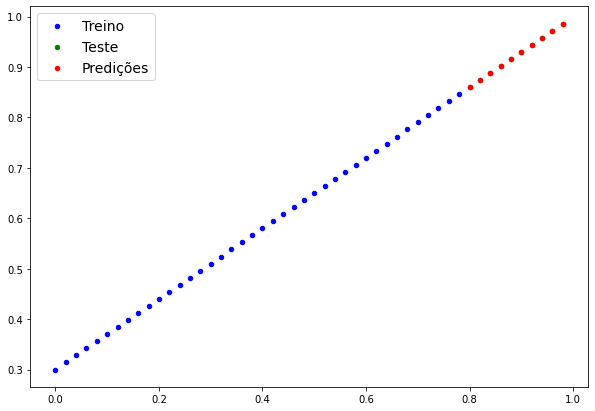

In [64]:
plot_predictions(X_train.cpu(), y_train.cpu(), 
                 X_test.cpu(), y_test.cpu(),
                 preds.cpu())

### 6.5 Salvando e carregando o modelo

In [66]:
from pathlib import Path

MODEL_FOLDER_PATH = Path("./models")
MODEL_FOLDER_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_FOLDER_PATH / MODEL_NAME

In [67]:
torch.save(model_1.state_dict(), MODEL_SAVE_PATH)

In [69]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [70]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [71]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [74]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_preds = loaded_model_1(X_test)

all(preds == loaded_preds)

True